In [1]:
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow_addons as tfa

from tensorflow.keras.preprocessing import image as tfk_image
from tensorflow.keras.preprocessing.image import ImageDataGenerator as tfk_ImageDataGenerator

from tensorflow.python.keras.applications.efficientnet import EfficientNetB7 as tfk_BaseModel
from tensorflow.python.keras.applications.efficientnet import preprocess_input as tfk_preprocess_input

# pip install git+https://github.com/docPhil99/ImageDataAugmentor
from ImageDataAugmentor.image_data_augmentor import ImageDataAugmentor
import albumentations as A

import datetime, os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set();
from PIL import Image, ImageEnhance

from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, log_loss, accuracy_score
from sklearn.preprocessing import OneHotEncoder

## Load Dataset

In [2]:
pd_train = pd.read_csv('shopee-product-detection-dataset/train.csv').sort_values(by=['filename'])
pd_confusing_images = pd.read_csv('shopee-product-detection-dataset/confusing_images_2__mistake_ratio=0.9.csv').sort_values(by=['filename'])

pd_train['dir_filename'] = pd_train.apply(lambda x: '{:02d}/{}'.format(x.category, x.filename), axis=1)
pd_train['category']     = pd_train['category'].apply(lambda x : '{:02d}'.format(x))

In [3]:
classes = np.unique(pd_train['category'])
classes

array(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10',
       '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21',
       '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32',
       '33', '34', '35', '36', '37', '38', '39', '40', '41'], dtype=object)

In [4]:
input_shape = (256, 256, 3)
batch_size  = 64

In [5]:
AUGMENTATIONS = A.Compose([
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.Rotate(),
    A.OneOf([
        A.RandomContrast(),
        A.RandomGamma(),
        A.RandomBrightness(),
    ], p = 0.3),
    A.OneOf([
        A.ElasticTransform(
            alpha = 120,
            sigma = 120 * 0.05,
            alpha_affine = 120 * 0.03
        ),
        A.GridDistortion(),
        A.OpticalDistortion(
            distort_limit = 2,
            shift_limit = 0.5
        ),
    ], p = 0.3),
    A.OneOf([
        A.Cutout(
            num_holes=4,
            max_h_size=64,
            max_w_size=64
        ),
        A.GridDropout(
            ratio=0.25,
            holes_number_x=8,
            holes_number_y=8
        ),
    ], p=1),
])

In [6]:
train_datagen = ImageDataAugmentor(
    preprocess_input=tfk_preprocess_input,
    validation_split=0.1,
    augment=AUGMENTATIONS,
)

train_generator = train_datagen.flow_from_dataframe(
    pd_train,
    directory='shopee-product-detection-dataset/train/',
    x_col='dir_filename',
    y_col='category',
    target_size=input_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

val_generator = train_datagen.flow_from_dataframe(
    pd_train,
    directory='shopee-product-detection-dataset/train/',
    x_col='dir_filename',
    y_col='category',
    target_size=input_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='validation'
)

Found 94853 validated image filenames belonging to 42 classes.
Found 10539 validated image filenames belonging to 42 classes.


## Prepare Model

In [ ]:
base_model = tfk_BaseModel(input_shape=input_shape, weights='imagenet', include_top=False)

In [ ]:
TYPE = 3
if TYPE == 1:
    for layer in base_model.layers[:-18]:
        layer.trainable = False
    model = tfk.Sequential([
        base_model,
        tfk.layers.GlobalMaxPooling2D(),
        tfk.layers.Dense(512, activation='relu'),
        tfk.layers.Dense(128, activation='relu'),
        tfk.layers.Dense(42, activation='softmax', name='output_layer'),
    ])
elif TYPE == 2:
    model = tfk.Sequential([
        base_model,
        tfk.layers.GlobalMaxPooling2D(),
        tfk.layers.Dropout(rate=0.2),
        tfk.layers.Dense(42, activation='softmax', name='output_layer'),
    ])
    base_model.trainable = False
elif TYPE == 3:
    for layer in base_model.layers[:-len(base_model.layers)//5]:
        layer.trainable = False
    model = tfk.Sequential([
        base_model,
        tfk.layers.GlobalMaxPooling2D(),
        tfk.layers.Dropout(rate=0.2),
        tfk.layers.Dense(42, activation='softmax', name='output_layer'),
    ])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb7 (Model)       (None, 8, 8, 2560)        64097687  
_________________________________________________________________
global_max_pooling2d (Global (None, 2560)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2560)              0         
_________________________________________________________________
output_layer (Dense)         (None, 42)                107562    
Total params: 64,205,249
Trainable params: 38,267,402
Non-trainable params: 25,937,847
_________________________________________________________________


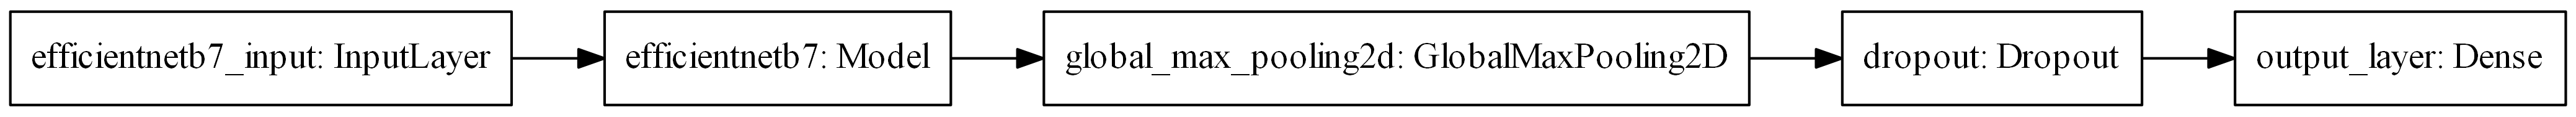

In [10]:
tfk.utils.plot_model(model, rankdir='LR', dpi=300, show_shapes=False)

## Train Top Layers of Model

In [7]:
model = tfk.models.load_model('model_aug_full_1.h5')

train step size: 1482
  val step size: 164


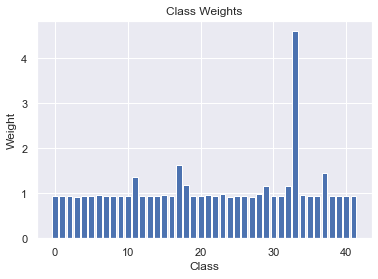

In [8]:
class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(train_generator.classes),
                                                  train_generator.classes)
class_weights = {i : class_weights[i] for i in range(len(class_weights))}
plt.title("Class Weights")
plt.ylabel("Weight")
plt.xlabel("Class")
plt.bar(class_weights.keys(), class_weights.values())

train_step_size = train_generator.n//train_generator.batch_size
val_step_size   = val_generator.n//val_generator.batch_size
print("train step size:", train_step_size)
print("  val step size:", val_step_size)

In [9]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.3,
    patience=10,
    min_lr=1e-6
)

early_stop = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=30,
    restore_best_weights=True
)

log_dir = os.path.join(".model_files/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

checkpoint = tfk.callbacks.ModelCheckpoint(
    filepath = log_dir + '/ckpt/',
    save_freq ='epoch',
    save_best_only=True,
    monitor='val_accuracy'
)

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=0,
    update_freq=100,
    write_graph=False,
    profile_batch = 0
)

class LRTensorBoard(tf.keras.callbacks.TensorBoard):
    def __init__(self, log_dir, **kwargs):  # add other arguments to __init__ if you need
        super().__init__(log_dir=log_dir, **kwargs)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        lr_sched = getattr(self.model.optimizer, "lr", None)
        logs.update({'lr': tf.keras.backend.get_value(lr_sched(tf.cast(self.model.optimizer.iterations, tf.float32)))})
        super().on_epoch_end(epoch, logs)

lr_tensorboard_callback = LRTensorBoard(log_dir=log_dir)
        
#tqdm_callback = tfa.callbacks.TQDMCallback()

In [10]:
lr_schedule = tfa.optimizers.ExponentialCyclicalLearningRate(
    initial_learning_rate=1e-6,
    maximal_learning_rate=1e-3,
    step_size=2*train_generator.n//batch_size
)

model.compile(optimizer=tfk.optimizers.Adam(learning_rate=1e-4),
              loss=tfk.losses.CategoricalCrossentropy(label_smoothing=0.1),
              metrics=['accuracy'])

In [41]:
history = model.fit(train_generator,
                    initial_epoch=101,
                    epochs=200,
                    steps_per_epoch=200,
                    validation_steps=20,
                    validation_data=val_generator,
                    class_weight=class_weights,
                    callbacks=[reduce_lr,
                               early_stop, 
                               #checkpoint, 
                               tensorboard_callback,
                               #lr_tensorboard_callback,
                               #tqdm_callback
                              ]
                   )

Epoch 102/200
200/200 [==============================] - 217s 1s/step - loss: 1.4146 - accuracy: 0.7529 - val_loss: 1.5699 - val_accuracy: 0.7234 - lr: 3.0000e-05
Epoch 103/200
200/200 [==============================] - 217s 1s/step - loss: 1.4157 - accuracy: 0.7562 - val_loss: 1.5638 - val_accuracy: 0.7172 - lr: 3.0000e-05
Epoch 104/200
200/200 [==============================] - 218s 1s/step - loss: 1.4009 - accuracy: 0.7575 - val_loss: 1.5379 - val_accuracy: 0.7352 - lr: 3.0000e-05
Epoch 105/200
200/200 [==============================] - 218s 1s/step - loss: 1.3954 - accuracy: 0.7582 - val_loss: 1.5394 - val_accuracy: 0.7258 - lr: 3.0000e-05
Epoch 106/200
200/200 [==============================] - 218s 1s/step - loss: 1.4129 - accuracy: 0.7518 - val_loss: 1.5913 - val_accuracy: 0.7242 - lr: 3.0000e-05
Epoch 107/200
200/200 [==============================] - 218s 1s/step - loss: 1.4142 - accuracy: 0.7515 - val_loss: 1.5509 - val_accuracy: 0.7250 - lr: 3.0000e-05
Epoch 108/200
200/200 

KeyboardInterrupt: 

In [42]:
model.save('model_aug_full_4.h5')

## Testing

In [43]:
# model = tfk.models.load_model('model_clean_3.h5')

In [44]:
clean_datagen = tfk_ImageDataGenerator(
    preprocessing_function=tfk_preprocess_input,
)

clean_generator = clean_datagen.flow_from_dataframe(
    pd_train,
    directory='shopee-product-detection-dataset/train/',
    x_col='dir_filename',
    y_col='category',
    target_size=input_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
)

Found 105392 validated image filenames belonging to 42 classes.


In [45]:
%%time
y_pred = []
y_true = []

for i in range(50):
    if (i+1) % 10 == 0:
        print("step:", i+1)
    x, y = next(iter(clean_generator))
    y_true.extend(y)
    y_pred.extend(model.predict(x))

y_pred = np.array(y_pred)
y_true = np.array(y_true)

step: 10
step: 20
step: 30
step: 40
step: 50
Wall time: 50.4 s


In [46]:
matrix = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))

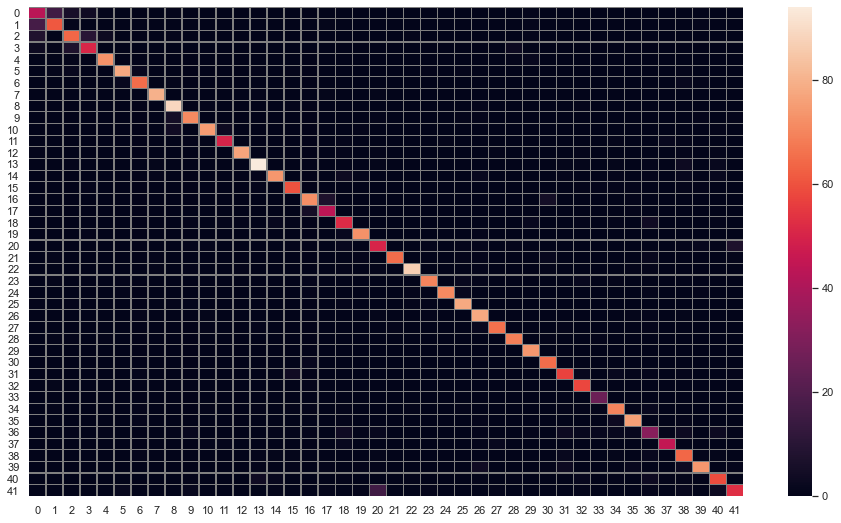

In [47]:
plt.figure(figsize = (16,9))
sns.heatmap(matrix, linecolor='grey', linewidth=0.1)
plt.savefig('confusion_matrix.png', 
            #transparent=True,
            bbox_inches='tight')

In [48]:
def label_smoother(x, alpha=0.1):
    return (1 - alpha) * x + alpha / x.shape[1]

In [49]:
loss     = tfk.losses.categorical_crossentropy(y_pred, label_smoother(y_true, alpha=0.1)).numpy().mean()
accuracy = accuracy_score(y_pred.argmax(axis=1), y_true.argmax(axis=1))

print("Loss:", loss)
print("Accuracy:", accuracy)

Loss: 1.7350804
Accuracy: 0.8540625


## Generate Submission

In [50]:
pd_test = pd.read_csv('shopee-product-detection-dataset/test.csv')
pd_test.head()

,filename,category
0,fd663cf2b6e1d7b02938c6aaae0a32d2.jpg,43
1,c7fd77508a8c355eaab0d4e10efd6b15.jpg,43
2,127f3e6d6e3491b2459812353f33a913.jpg,43
3,5ca4f2da11eda083064e6c36f37eeb81.jpg,43
4,46d681a542f2c71be017eef6aae23313.jpg,43


In [51]:
test_datagen = tfk_ImageDataGenerator(
    preprocessing_function=tfk_preprocess_input
)

test_generator = test_datagen.flow_from_dataframe(
    pd_test,
    directory='shopee-product-detection-dataset/test/',
    x_col='filename',
    target_size=input_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    class_mode=None,
    shuffle=False,
)

Found 12186 validated image filenames.


In [52]:
y_pred = model.predict(test_generator, verbose=1, steps=test_generator.n//batch_size+1)
y_pred = y_pred[:test_generator.n]

191/191 [==============================] - 136s 711ms/step


In [53]:
pd_submission = pd_test.copy()
pd_submission['category'] = list(map(lambda x : '{:02d}'.format(x), y_pred.argmax(axis=1)))
pd_submission.head()

,filename,category
0,fd663cf2b6e1d7b02938c6aaae0a32d2.jpg,20
1,c7fd77508a8c355eaab0d4e10efd6b15.jpg,27
2,127f3e6d6e3491b2459812353f33a913.jpg,04
3,5ca4f2da11eda083064e6c36f37eeb81.jpg,22
4,46d681a542f2c71be017eef6aae23313.jpg,12


In [54]:
pd_submission.to_csv('submission_10.csv', index=False)

In [59]:
now  = 10
cat_now_name  = 'category_{}'.format(now)
prev = 1
cat_prev_name = 'category_{}'.format(prev)

pd_submission_prev = pd.read_csv('submission_{}.csv'.format(prev))
pd_submission_prev['category'] = pd_submission_prev['category'].apply(lambda x : '{:02d}'.format(x))
pd_submission_prev.columns = ['filename', cat_prev_name]
pd_submission_prev = pd_submission_prev.merge(pd_submission.sort_values(by='filename'), on='filename')
pd_iba = pd_submission_prev[pd_submission_prev[cat_prev_name] != pd_submission_prev['category']]
print(len(pd_iba), len(pd_submission_prev), len(pd_iba) / len(pd_submission_prev))
pd_iba.head(20)

240 12186 0.019694731659281144


,filename,category_9,category
57,7fbe6dd0725f45bb33ff69c2e2a5b3f9.jpg,02,40
76,b0d4ab50e7b37235ae7f10bf7c889706.jpg,25,38
144,a346dfebd54ca98df578cca8b42e6c78.jpg,21,30
171,d9be3db716fe72bb6609e3f8d9975f7c.jpg,15,31
195,44dcb05b2c69a5e7c949fc2ea8b53535.jpg,03,02
255,adf93e1842c447d16450d6662d24c7ba.jpg,00,02
284,5dd9c97ce2c40ff4e9c1a543eb69be1d.jpg,19,35
300,8eaca4ab9a2b78af894f70c1f7a2efe7.jpg,15,40
316,588489cd8d68281e3789ce932c74a8dc.jpg,40,18
370,6891cff16d54a25eff9fd6df093177ce.jpg,20,41


In [60]:
pd_iba.to_csv("iba.csv", index=False)

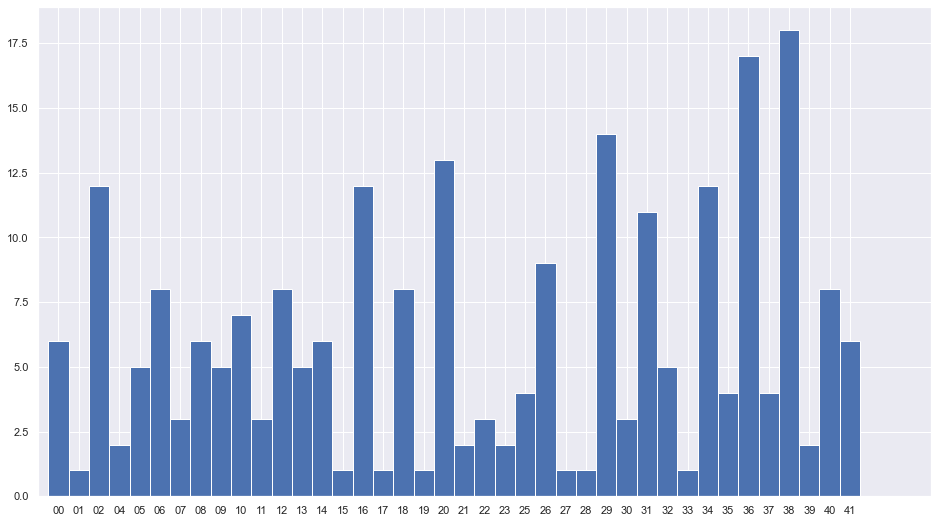

In [61]:
plt.figure(figsize=(16, 9))
plt.hist(pd_iba['category'].sort_values(), bins=np.arange(43)-0.5)
plt.xlim(-1, 43)
plt.show()